# Using Machine Learning and Credit Card Data to Predict Customer Attrition (Coursework Code for COP528)

This Jupyter Notebook file demonstrates a machine learning pipeline for the COP528 coursework.

The context of the data and the classification task is as follows:

*A business manager of a consumer credit card portfolio is facing the problem of
customer attrition. They want to analyse the data to find out the reason behind this
and leverage the same to predict customers who are likely to drop off.*

The Machine Learning Pipeline in this file is as follows:
1. Preliminary Analysis and Preprocessing
    * Read Data
    * Clean Data
    * Visualise Data
2. Split Data into Train and Test
4. Feature Selection
    * Logisitic Regression
    * Decision Tree
    * Combined Feature Selection
5. Classification
    * Standardise Training Data
    * kNN
    * SVM
6. Evaluation
    * Standardise and Apply Feature Selection to Test Data
    * Test Tuned kNN
    * Test Tuned SVM

# Import Packages

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Preliminary Analysis and Preprocessing

## Read Data

In [32]:
df = pd.read_csv('data/BankChurners.csv')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

## Clean Data

In [33]:
# check client number for duplicates and drop any other duplicates
print(df.CLIENTNUM.nunique())
df.drop_duplicates(inplace = True)
df.drop(columns = ['CLIENTNUM'], inplace = True)

# make list of features and categorical features
feature_list = list(df.columns)
cat_features = [feature_list[2]] + feature_list[4:8]

# print count of category in each categorical feature
print(df['Attrition_Flag'].value_counts())
for features in cat_features:
    print(df[features].value_counts())
    
# remove samples with unknown
df = df[df['Education_Level'].str.contains('Unknown')==False]
df = df[df['Marital_Status'].str.contains('Unknown')==False]
df = df[df['Income_Category'].str.contains('Unknown')==False]
df = df.reset_index(drop = True)

# print new count of category in each categorical feature
print('\n')
print(df['Attrition_Flag'].value_counts())
for features in cat_features:
    print(df[features].value_counts())

10127
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
F    5358
M    4769
Name: Gender, dtype: int64
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64


Existing Customer    5968
Attrited Customer    1113
Name: Attrition_Flag, dtype: int64
M    3706
F    3375
Name: Gender, dtype: int64
Graduate         2591
High School      1653
Uneducated       1204
College           844
Post-Graduate     431
Doctorate         358
Name: Education_Level, 

In [34]:
df.describe(include = "all")

Attrition_Flag  Customer_Age Gender  Dependent_count  \
count                7081   7081.000000   7081      7081.000000   
unique                  2           NaN      2              NaN   
top     Existing Customer           NaN      M              NaN   
freq                 5968           NaN   3706              NaN   
mean                  NaN     46.347691    NaN         2.337805   
std                   NaN      8.041225    NaN         1.291649   
min                   NaN     26.000000    NaN         0.000000   
25%                   NaN     41.000000    NaN         1.000000   
50%                   NaN     46.000000    NaN         2.000000   
75%                   NaN     52.000000    NaN         3.000000   
max                   NaN     73.000000    NaN         5.000000   

       Education_Level Marital_Status Income_Category Card_Category  \
count             7081           7081            7081          7081   
unique               6              3               5             4   
top           Graduate        Married  Less than $40K          Blue   
freq              2591           3564            2792          6598   
mean               NaN            NaN             NaN           NaN   
std                NaN            NaN             NaN           NaN   
min                NaN            NaN             NaN           NaN   
25%                NaN            NaN             NaN           NaN   
50%                NaN            NaN             NaN           NaN   
75%                NaN            NaN             NaN           NaN   
max                NaN            NaN             NaN           NaN   

        Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
count      7081.000000               7081.000000             7081.000000   
unique             NaN                       NaN                     NaN   
top                NaN                       NaN                     NaN   
freq               NaN                       NaN                     NaN   
mean         35.981359                  3.819376                2.342607   
std           8.002609                  1.544444                0.995104   
min          13.000000                  1.000000                0.000000   
25%          31.000000                  3.000000                2.000000   
50%          36.000000                  4.000000                2.000000   
75%          40.000000                  5.000000                3.000000   
max          56.000000                  6.000000                6.000000   

        Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count             7081.000000   7081.000000          7081.000000   
unique                    NaN           NaN                  NaN   
top                       NaN           NaN                  NaN   
freq                      NaN           NaN                  NaN   
mean                 2.454456   8492.773831          1167.501624   
std                  1.104917   9126.072520           812.315606   
min                  0.000000   1438.300000             0.000000   
25%                  2.000000   2498.000000           463.000000   
50%                  2.000000   4287.000000          1282.000000   
75%                  3.000000  10729.000000          1781.000000   
max                  6.000000  34516.000000          2517.000000   

        Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  \
count       7081.000000           7081.000000      7081.000000   
unique              NaN                   NaN              NaN   
top                 NaN                   NaN              NaN   
freq                NaN                   NaN              NaN   
mean        7325.272207              0.760584      4394.299816   
std         9131.217585              0.223139      3468.461606   
min            3.000000              0.000000       510.000000   
25%         1248.000000              0.629000      2089.000000   
50%         3250.000000      

In [35]:
# encode ordered categories
OrdEnc1 = OrdinalEncoder(categories=[['Uneducated', 'High School', 'College', 
                                      'Graduate', 'Post-Graduate', 'Doctorate']])
OrdEnc1.fit(df[['Education_Level']])
df[['Education_Level']] = OrdEnc1.transform(df[['Education_Level']])

OrdEnc2 = OrdinalEncoder(categories=[['Less than $40K', '$40K - $60K', 
                                      '$60K - $80K', '$80K - $120K',
                                      '$120K +']])
OrdEnc2.fit(df[['Income_Category']])
df[['Income_Category']] = OrdEnc2.transform(df[['Income_Category']])

OrdEnc3 = OrdinalEncoder(categories=[['Blue', 'Silver', 'Gold', 'Platinum']])

OrdEnc3.fit(df[['Card_Category']])
df[['Card_Category']] = OrdEnc3.transform(df[['Card_Category']])

# encode non ordered category
OHEnc = OneHotEncoder()
OHEnc.fit(np.asarray(df[['Marital_Status']]))
OHEnc_df = pd.DataFrame(OHEnc.transform(np.asarray(df[['Marital_Status']]))\
                        .toarray())

# encode binary category
df.replace({'Gender': {'M': 1, 'F': 0}}, inplace = True)

# check which categories correspond to which numbers
print(df['Attrition_Flag'].value_counts())
for features in cat_features:
    print(df[features].value_counts())

# add one hot encoded maritual status to df
df[['Divorced', 'Married', 'Single']] = OHEnc_df
df.drop(columns = ['Marital_Status'], inplace = True)

# make new list of features
feature_list = list(df.columns)
feature_list = feature_list[1:]

# check number in each Marital_Status category is correct
print('\n')
print(f"Single {sum(df['Single'])}")
print(f"Married {sum(df['Married'])}")
print(f"Divorced {sum(df['Divorced'])}")

Existing Customer    5968
Attrited Customer    1113
Name: Attrition_Flag, dtype: int64
1    3706
0    3375
Name: Gender, dtype: int64
3.0    2591
1.0    1653
0.0    1204
2.0     844
4.0     431
5.0     358
Name: Education_Level, dtype: int64
Married     3564
Single      2948
Divorced     569
Name: Marital_Status, dtype: int64
0.0    2792
1.0    1412
3.0    1202
2.0    1103
4.0     572
Name: Income_Category, dtype: int64
0.0    6598
1.0     391
2.0      81
3.0      11
Name: Card_Category, dtype: int64


Single 2948.0
Married 3564.0
Divorced 569.0


In [36]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7081 entries, 0 to 7080
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            7081 non-null   object 
 1   Customer_Age              7081 non-null   int64  
 2   Gender                    7081 non-null   int64  
 3   Dependent_count           7081 non-null   int64  
 4   Education_Level           7081 non-null   float64
 5   Income_Category           7081 non-null   float64
 6   Card_Category             7081 non-null   float64
 7   Months_on_book            7081 non-null   int64  
 8   Total_Relationship_Count  7081 non-null   int64  
 9   Months_Inactive_12_mon    7081 non-null   int64  
 10  Contacts_Count_12_mon     7081 non-null   int64  
 11  Credit_Limit              7081 non-null   float64
 12  Total_Revolving_Bal       7081 non-null   int64  
 13  Avg_Open_To_Buy           7081 non-null   float64
 14  Total_Am

Attrition_Flag  Customer_Age  Gender  Dependent_count  Education_Level  \
0  Existing Customer            45       1                3              1.0   
1  Existing Customer            49       0                5              3.0   
2  Existing Customer            51       1                3              3.0   
3  Existing Customer            40       1                3              0.0   
4  Existing Customer            44       1                2              3.0   

   Income_Category  Card_Category  Months_on_book  Total_Relationship_Count  \
0              2.0            0.0              39                         5   
1              0.0            0.0              44                         6   
2              3.0            0.0              36                         4   
3              2.0            0.0              21                         5   
4              1.0            0.0              36                         3   

   Months_Inactive_12_mon  ...  Total_Revolving_Bal  Avg_Open_To_Buy  \
0                       1  ...                  777          11914.0   
1                       1  ...                  864           7392.0   
2                       1  ...                    0           3418.0   
3                       1  ...                    0           4716.0   
4                       1  ...                 1247           2763.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 2.175              816              28                2.500   
4                 1.376             1088              24                0.846   

   Avg_Utilization_Ratio  Divorced  Married  Single  
0                  0.061       0.0      1.0     0.0  
1                  0.105       0.0      0.0     1.0  
2                  0.000       0.0      1.0     0.0  
3                  0.000       0.0      1.0     0.0  
4                  0.311       0.0      1.0     0.0  

[5 rows x 22 columns]

## Visualising data

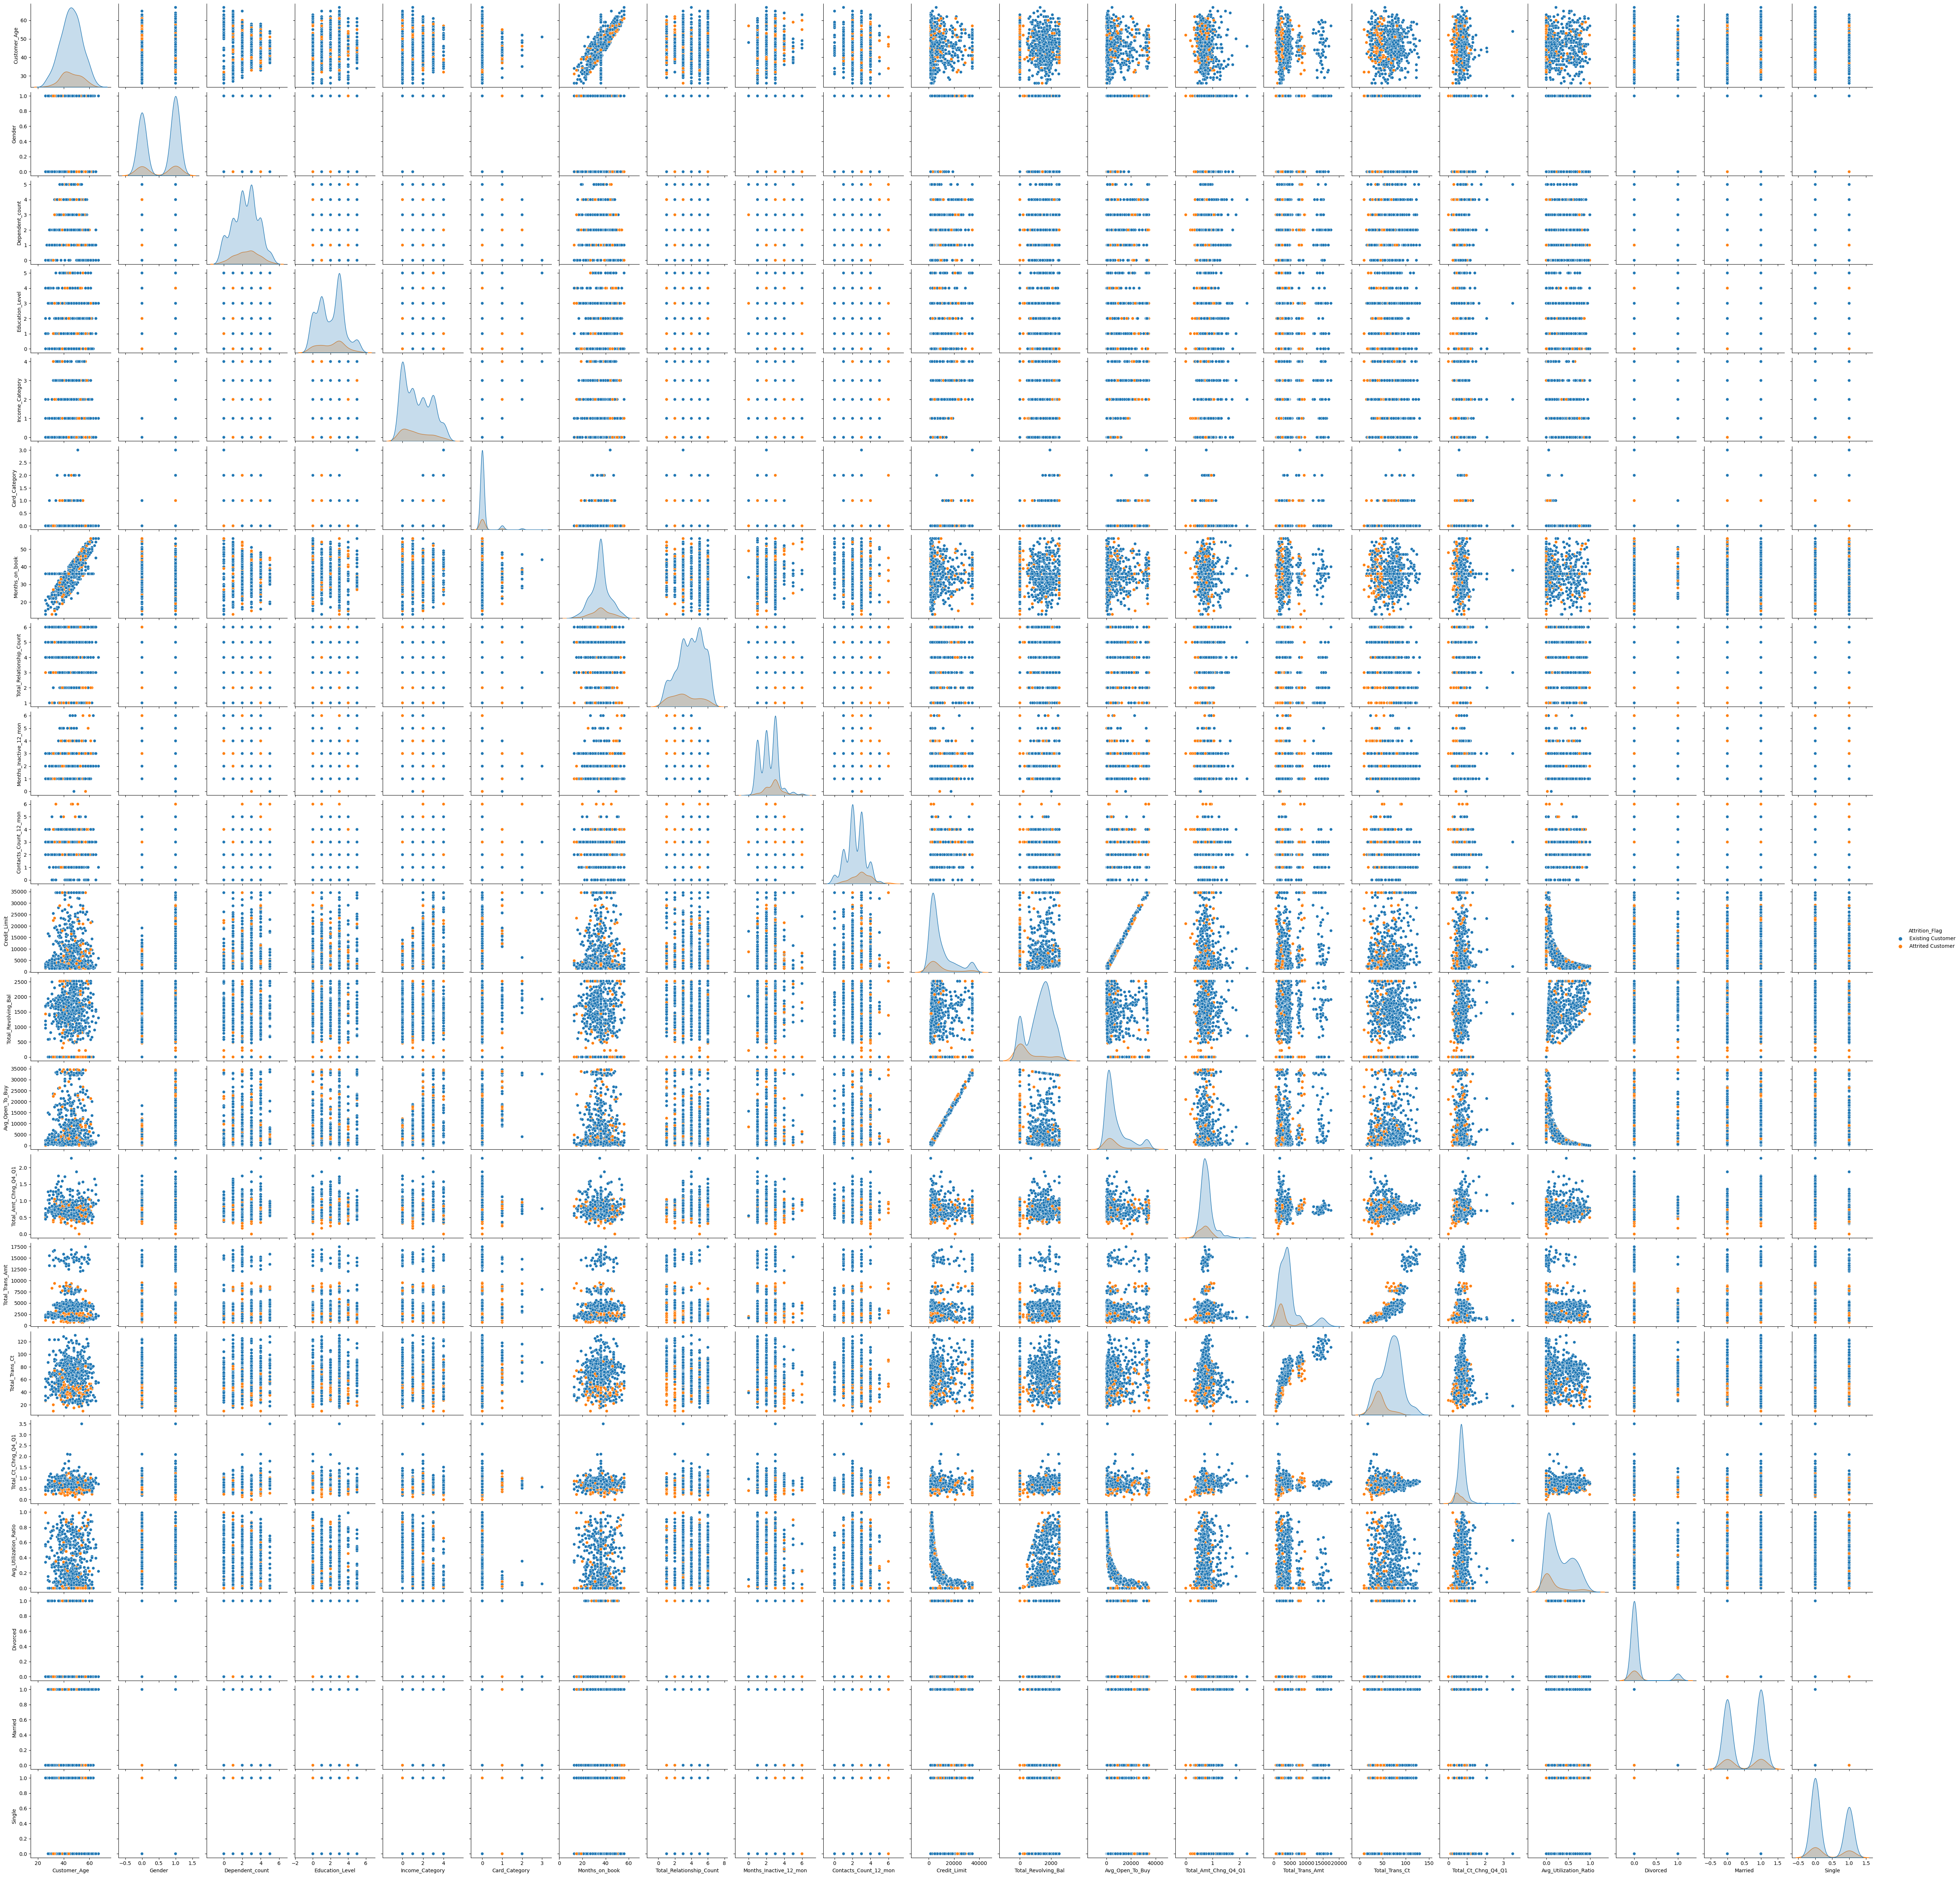

In [37]:
### This code chunk takes a long time to load ###

# downsample data for pairplot
df_sample = df.sample(frac = 0.1, axis = 0, random_state = 42)

# pairplot
sns.pairplot(df_sample, hue = 'Attrition_Flag', vars = feature_list)
plt.savefig("pairplot.png")
plt.show()

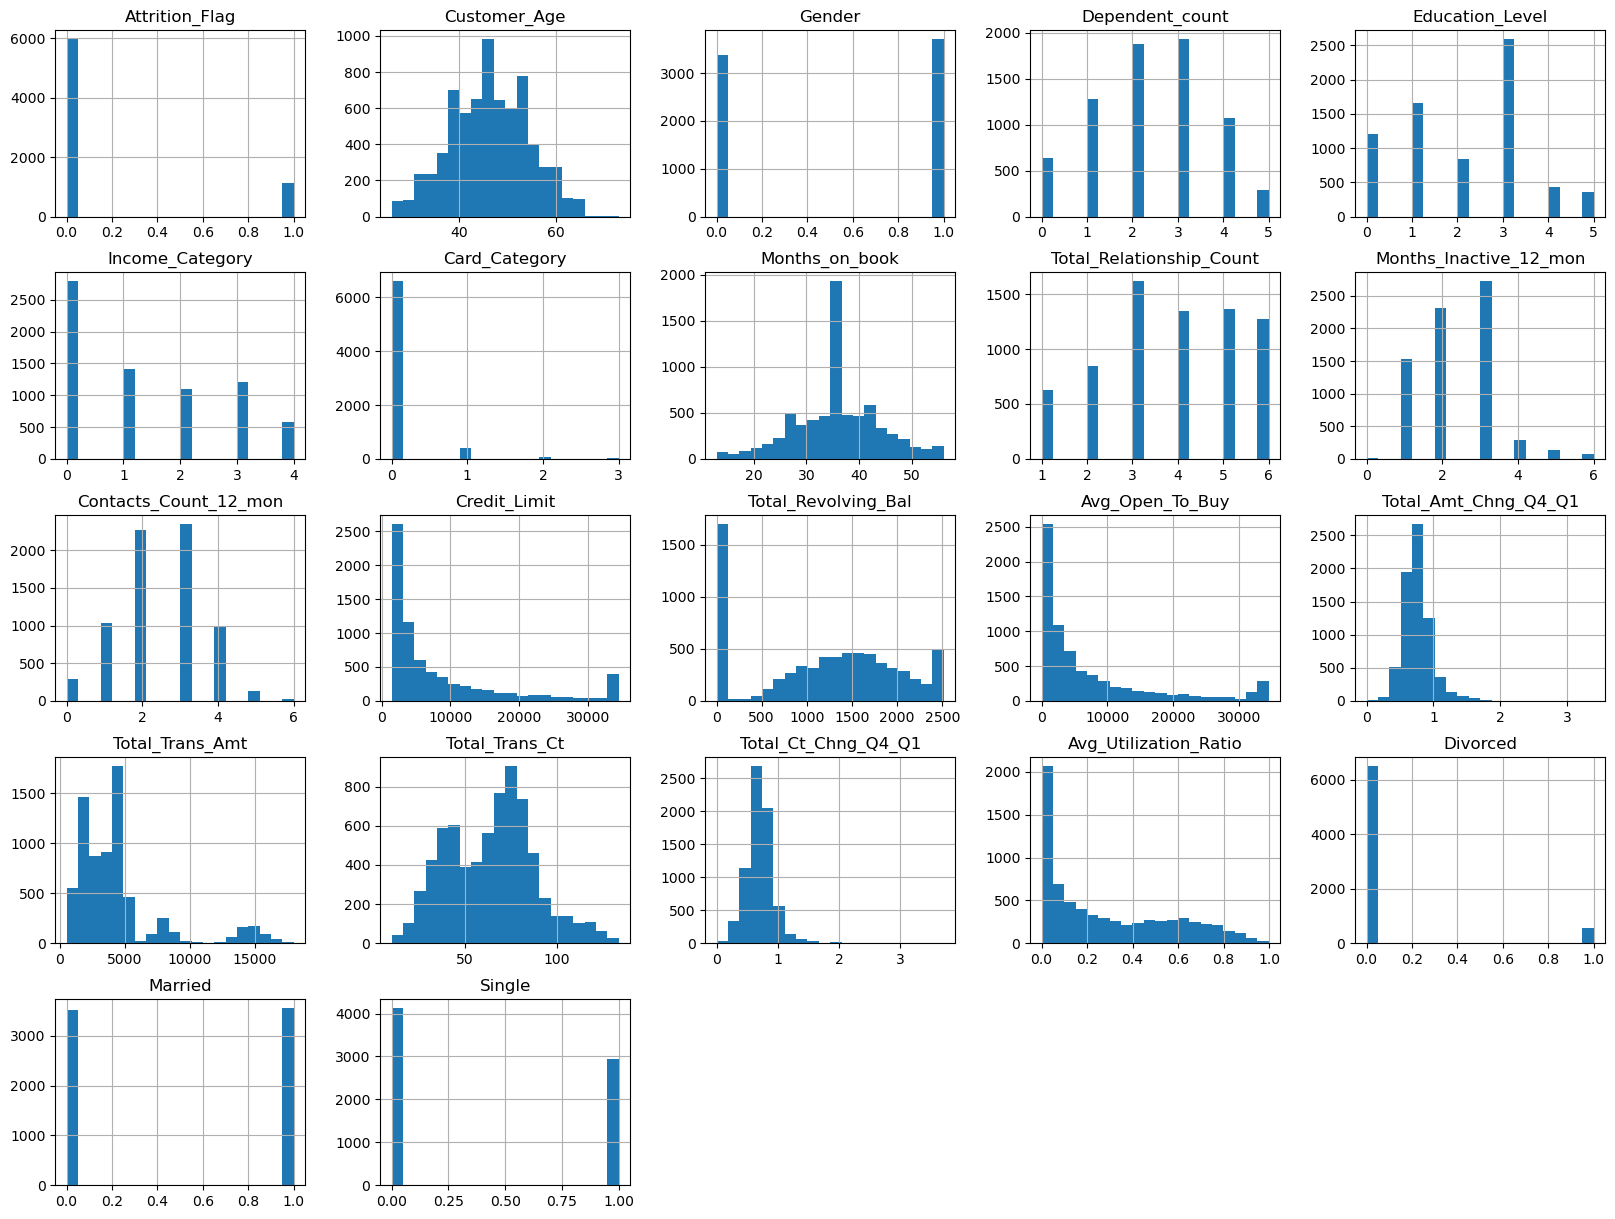

In [38]:
# binary encode class
df.replace({'Attrition_Flag': {'Existing Customer': 0, 'Attrited Customer': 1}}, 
           inplace = True)

# histgrams plot
df.hist(bins = 20, figsize = (20, 15))
plt.savefig("histplot.png")
plt.show()

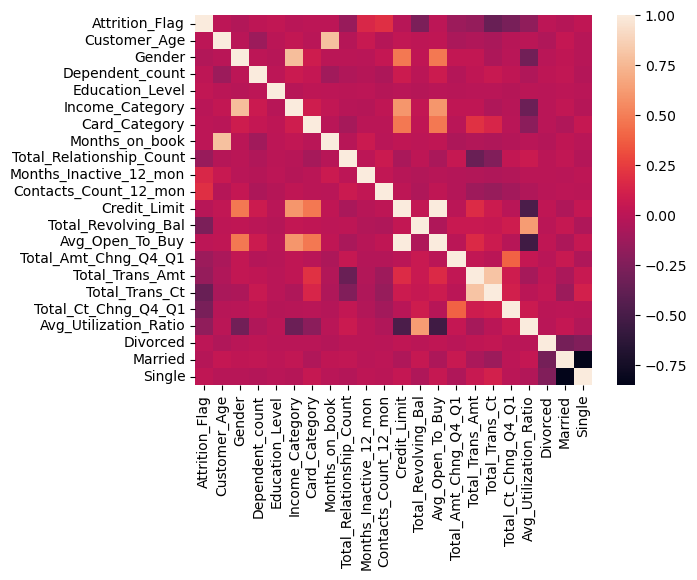

In [39]:
# correlations plot
sns.heatmap(df.corr())
plt.savefig("corrplot.png")
plt.show()

# Split Data into Train and Test

In [40]:
# convert df to numpy array
data = np.asarray(df)

# split data into X (features) and y (class)
X = data[:,1:]
y = data[:,:1]
y = y.ravel()

# constants
RANDOM_STATE = 42
kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = RANDOM_STATE)
minmax_scaler = MinMaxScaler()
stand_scaler = StandardScaler()
class_key = '      0 = Existing Customer     1 = Attrited Customer\n'



# split data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)

# Feature Selection

## Logistic Regression

In [41]:
# min max scale data
minmax_scaler.fit(X_train)
X_train_mm = minmax_scaler.transform(X_train)

# logistic regression
LR_clf_mm = LogisticRegression(solver = 'lbfgs', max_iter = 8000)
LR_clf_mm.fit(X_train_mm, y_train)

# k-fold cross validation
record_index = 0
coef_df = pd.DataFrame()
for train, test in kf.split(X_train_mm, y_train):
    kfold_LR_clf_mm = LR_clf_mm.fit(X_train_mm[train], y_train[train])
    coef_list = map(abs, kfold_LR_clf_mm.coef_[0])
    record_index = record_index + 1
    coef_df[record_index] = pd.DataFrame({record_index:coef_list})    

# create df of features and coefficients
coef_df['Coefficient'] = coef_df.mean(axis = 1)
coef_df = coef_df[['Coefficient']]
coef_df['Feature Names'] = feature_list
coef_df = coef_df[['Feature Names', 'Coefficient']]
coef_df

Feature Names  Coefficient
0               Customer_Age     0.676711
1                     Gender     0.787236
2            Dependent_count     0.330425
3            Education_Level     0.206439
4            Income_Category     0.582062
5              Card_Category     0.744558
6             Months_on_book     0.150997
7   Total_Relationship_Count     2.148838
8     Months_Inactive_12_mon     2.487002
9      Contacts_Count_12_mon     2.320988
10              Credit_Limit     0.260422
11       Total_Revolving_Bal     2.233122
12           Avg_Open_To_Buy     0.086768
13      Total_Amt_Chng_Q4_Q1     1.607920
14           Total_Trans_Amt     3.715526
15            Total_Trans_Ct     9.475731
16       Total_Ct_Chng_Q4_Q1     5.256772
17     Avg_Utilization_Ratio     0.328736
18                  Divorced     0.196267
19                   Married     0.303256
20                    Single     0.106553

## Decision Tree

In [42]:
# decision tree
DT_clf = DecisionTreeClassifier(criterion = 'entropy',
                                random_state = RANDOM_STATE)
DT_clf.fit(X_train, y_train)

# k-fold cross validation
record_index = 0
importance_df = pd.DataFrame()
for train, test in kf.split(X_train, y_train):
    kfold_DT_clf = DT_clf.fit(X_train[train], y_train[train])
    record_index = record_index + 1
    importance = DT_clf.feature_importances_
    importance_df[record_index] = pd.DataFrame({record_index:importance})

# create df of features and importance scores
importance_df['Importance Score'] = importance_df.mean(axis = 1)
importance_df = importance_df[['Importance Score']]
importance_df['Feature Names'] = feature_list
importance_df = importance_df[['Feature Names', 'Importance Score']]
importance_df

Feature Names  Importance Score
0               Customer_Age          0.031794
1                     Gender          0.002946
2            Dependent_count          0.009274
3            Education_Level          0.005058
4            Income_Category          0.003976
5              Card_Category          0.001371
6             Months_on_book          0.010425
7   Total_Relationship_Count          0.070185
8     Months_Inactive_12_mon          0.015839
9      Contacts_Count_12_mon          0.012684
10              Credit_Limit          0.008900
11       Total_Revolving_Bal          0.160814
12           Avg_Open_To_Buy          0.016397
13      Total_Amt_Chng_Q4_Q1          0.054074
14           Total_Trans_Amt          0.181476
15            Total_Trans_Ct          0.327134
16       Total_Ct_Chng_Q4_Q1          0.067278
17     Avg_Utilization_Ratio          0.012808
18                  Divorced          0.002381
19                   Married          0.002575
20                    Single          0.002612

## Combined Feature Selection

In [43]:
# min-max normalisation of coef_df
coef_df = coef_df.drop('Feature Names', axis = 1)
coef_df_norm = (coef_df - coef_df.min()) / (coef_df.max() - coef_df.min())

# min-max normalisation of importance_df
importance_df = importance_df.drop('Feature Names', axis = 1)
importance_df_norm = (importance_df - importance_df.min())\
                      / (importance_df.max() - importance_df.min())

# combine dfs and order by score
feature_df = (np.asarray(coef_df_norm) + np.asarray(importance_df_norm)) / 2
feature_df = pd.DataFrame(feature_df)
feature_df['Feature Names'] = feature_list
feature_df = feature_df.rename(columns = {0: 'Score'})
feature_df = feature_df[['Feature Names', 'Score']]
feature_df.sort_values(by = 'Score', ascending = False, inplace = True)
feature_df

Feature Names     Score
15            Total_Trans_Ct  1.000000
14           Total_Trans_Amt  0.469682
16       Total_Ct_Chng_Q4_Q1  0.376482
11       Total_Revolving_Bal  0.359024
7   Total_Relationship_Count  0.215433
13      Total_Amt_Chng_Q4_Q1  0.161899
8     Months_Inactive_12_mon  0.150029
9      Contacts_Count_12_mon  0.136345
0               Customer_Age  0.078111
1                     Gender  0.039721
5              Card_Category  0.035030
17     Avg_Utilization_Ratio  0.030441
4            Income_Category  0.030374
2            Dependent_count  0.025105
12           Avg_Open_To_Buy  0.023062
10              Credit_Limit  0.020804
6             Months_on_book  0.017316
19                   Married  0.013376
3            Education_Level  0.012031
18                  Divorced  0.007381
20                    Single  0.002958

In [44]:
# create df with feature scores above median score
median = feature_df['Score'].median()
feature_df = feature_df[feature_df['Score'] > median]
feature_df.reset_index(inplace = True)
feature_df

index             Feature Names     Score
0     15            Total_Trans_Ct  1.000000
1     14           Total_Trans_Amt  0.469682
2     16       Total_Ct_Chng_Q4_Q1  0.376482
3     11       Total_Revolving_Bal  0.359024
4      7  Total_Relationship_Count  0.215433
5     13      Total_Amt_Chng_Q4_Q1  0.161899
6      8    Months_Inactive_12_mon  0.150029
7      9     Contacts_Count_12_mon  0.136345
8      0              Customer_Age  0.078111
9      1                    Gender  0.039721

In [45]:
# create new X with selected features
X_train_fs = pd.DataFrame(X_train)
X_train_fs = X_train_fs[feature_df['index']]
X_train_fs = np.asarray(X_train_fs)
X_train_fs.shape

(4956, 10)

# Classification

## Standardise Training Data

In [46]:
# standardise full X train data set
stand_scaler.fit(X_train)
X_train_std = stand_scaler.transform(X_train)

# standardise feature selected X train data set
stand_scaler.fit(X_train_fs)
X_train_fs_std = stand_scaler.transform(X_train_fs)

## kNN

### All Features vs Selected Features

kNN on All Features

              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      4177
         1.0       0.75      0.50      0.60       779

    accuracy                           0.90      4956
   macro avg       0.83      0.73      0.77      4956
weighted avg       0.89      0.90      0.89      4956



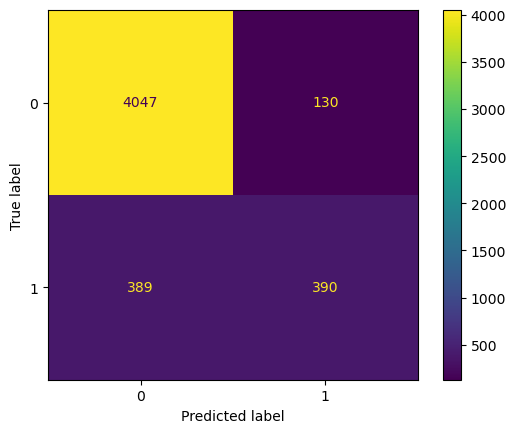

      0 = Existing Customer     1 = Attrited Customer

kNN on Selected Features

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      4177
         1.0       0.81      0.66      0.73       779

    accuracy                           0.92      4956
   macro avg       0.88      0.82      0.84      4956
weighted avg       0.92      0.92      0.92      4956



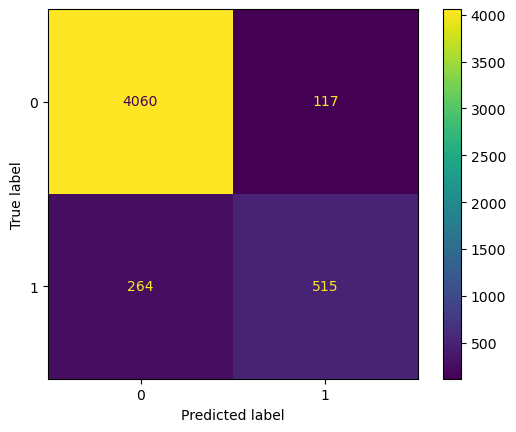

      0 = Existing Customer     1 = Attrited Customer



In [47]:
kNN_clf = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')


## All Features

# cross validation predictor
kNN_full_y_pred = cross_val_predict(kNN_clf, X_train_std, y_train, cv = kf)

# classification report
print('kNN on All Features\n')
print(classification_report(y_train, kNN_full_y_pred))

# confusion matrix
kNN_full_cm = confusion_matrix(y_train, kNN_full_y_pred, labels = [0, 1])
kNN_full_disp = ConfusionMatrixDisplay(confusion_matrix = kNN_full_cm,
                                        display_labels = [0, 1])
kNN_full_disp.plot()
plt.savefig("kNN_full.png")
plt.show()
print(class_key)


## Selected Features

# cross validation predictor
kNN_fs_y_pred = cross_val_predict(kNN_clf, X_train_fs_std, y_train, cv = kf)

# classification report
print('kNN on Selected Features\n')
print(classification_report(y_train, kNN_fs_y_pred))

# confusion matrix
kNN_fs_cm = confusion_matrix(y_train, kNN_fs_y_pred, labels = [0, 1])
kNN_fs_disp = ConfusionMatrixDisplay(confusion_matrix = kNN_fs_cm,
                                        display_labels = [0, 1])
kNN_fs_disp.plot()
plt.savefig("kNN_fs.png")
plt.show()
print(class_key)

### Hyperparameter Tuning

#### k Tuning

1: 0.910:
2: 0.910:
3: 0.923:
4: 0.923:
5: 0.923:
6: 0.923:
7: 0.923:
8: 0.924:
9: 0.926:
10: 0.928:
11: 0.926:
12: 0.926:
13: 0.925:
14: 0.926:
15: 0.924:
16: 0.924:
17: 0.924:
18: 0.924:
19: 0.924:
20: 0.924:
21: 0.923:
22: 0.921:
23: 0.922:
24: 0.921:
25: 0.922:


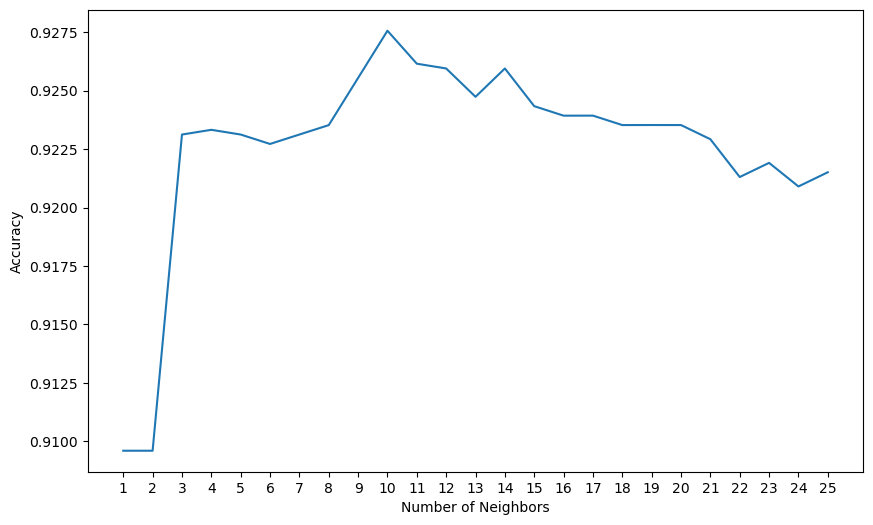

In [48]:
# Code adapted from: 
# [https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning].

# create list of accuracy scores for each value of k and print them
kNN_mean_acc = []
for i in range(1, 26):
    kNN_clf_tune = KNeighborsClassifier(n_neighbors = i, weights = 'distance')
    kNN_score = cross_val_score(kNN_clf_tune, X_train_fs_std, y_train, 
                                cv = kf, scoring = 'accuracy')
    kNN_score_mean = kNN_score.mean()
    kNN_mean_acc.append(kNN_score_mean)
    print(f"{i}: %.3f:" %(kNN_score_mean))

# plot accuracy scores against number of neighbours
loc = np.arange(1, 26, step = 1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, 26), kNN_mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.savefig("k_tuning.png")
plt.show()

#### Multi-parameter Tuning

In [49]:
### This code chunk takes a bit of time to load ###

# Code adapted from: 
# [https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning].

# remove warning messages
import warnings
warnings.filterwarnings("ignore")

# define parameter range
nn_list = list(range(9, 16))
kNN_grid_params = { 'n_neighbors' : nn_list,
                    'weights' : ['uniform','distance'],
                    'metric' : ['minkowski','euclidean','manhattan']}

# fit models in parameter range
kNN_grid = GridSearchCV(KNeighborsClassifier(), kNN_grid_params, refit = True, 
                        verbose = 1,  cv = kf)
kNN_grid.fit(X_train_fs_std, y_train)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [9, 10, 11, 12, 13, 14, 15],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [50]:
# print best parameters
print(kNN_grid.best_params_)
print(kNN_grid.best_score_)

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
0.9358325187357446


## SVM

### All Features vs Selected Features

SVM on All Features

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      4177
         1.0       0.77      0.54      0.64       779

    accuracy                           0.90      4956
   macro avg       0.85      0.76      0.79      4956
weighted avg       0.90      0.90      0.90      4956



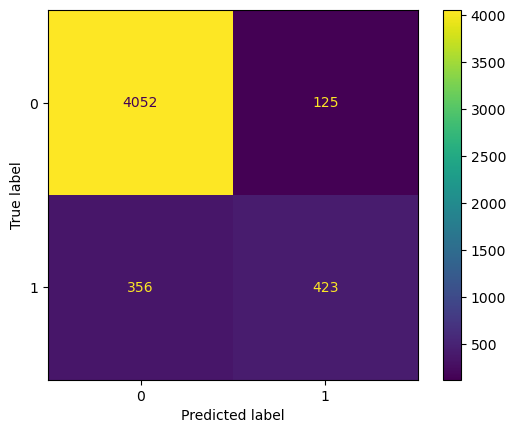

      0 = Existing Customer     1 = Attrited Customer

SVM on Selected Features

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      4177
         1.0       0.76      0.53      0.63       779

    accuracy                           0.90      4956
   macro avg       0.84      0.75      0.78      4956
weighted avg       0.89      0.90      0.89      4956



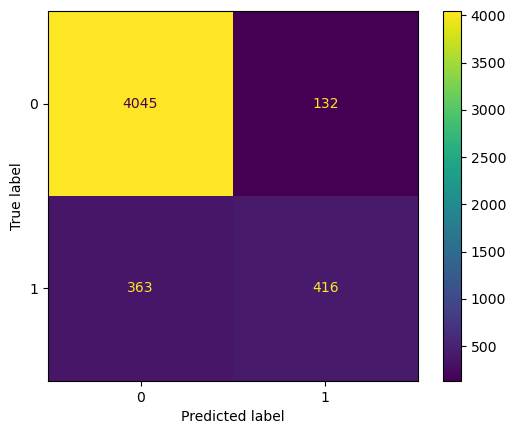

      0 = Existing Customer     1 = Attrited Customer



In [51]:
SVM_clf = SVC(kernel = 'linear')


## All Features

# cross validation predictor
SVM_full_y_pred = cross_val_predict(SVM_clf, X_train_std, y_train, cv = kf)

# classification report
print('SVM on All Features\n')
print(classification_report(y_train, SVM_full_y_pred))

# confusion matrix
SVM_full_cm = confusion_matrix(y_train, SVM_full_y_pred, labels = [0, 1])
SVM_full_disp = ConfusionMatrixDisplay(confusion_matrix = SVM_full_cm,
                                        display_labels = [0, 1])
SVM_full_disp.plot()
plt.savefig("SVM_full.png")
plt.show()
print(class_key)


## Selected Features

# cross validation predictor
SVM_fs_y_pred = cross_val_predict(SVM_clf, X_train_fs_std, y_train, cv = kf)

# classification report
print('SVM on Selected Features\n')
print(classification_report(y_train, SVM_fs_y_pred))

# confusion matrix
SVM_fs_cm = confusion_matrix(y_train, SVM_fs_y_pred, labels = [0, 1])
SVM_fs_disp = ConfusionMatrixDisplay(confusion_matrix = SVM_fs_cm,
                                        display_labels = [0, 1])
SVM_fs_disp.plot()
plt.savefig("SVM_fs.png")
plt.show()
print(class_key)

### Hyperparameter Tuning

#### C Tuning

0.1: 0.903:
0.5: 0.930:
1: 0.937:
5: 0.940:
10: 0.940:
50: 0.932:
100: 0.928:
500: 0.920:
1000: 0.914:
5000: 0.913:


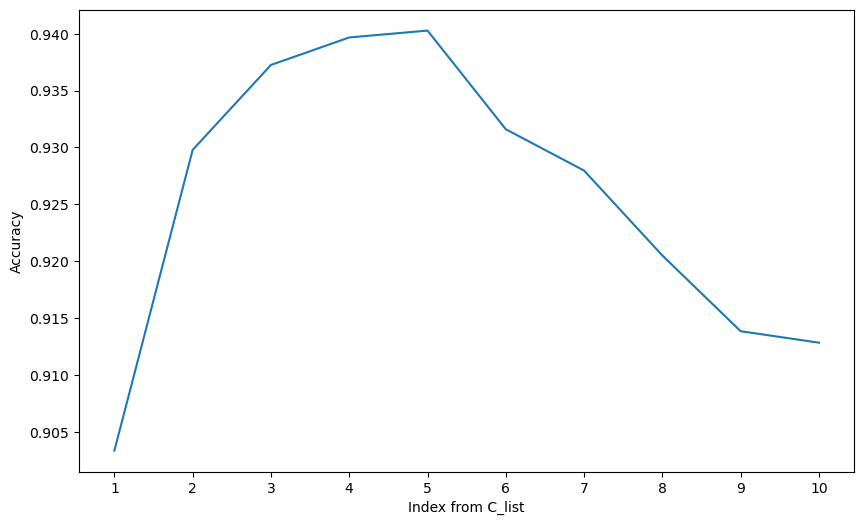

In [52]:
# Code adapted from: 
# [https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning].

# create list of accuracy scores for each value of C and print them
SVM_C_mean_acc = []
C_list = [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000]
for i in C_list:
    SVM_clf_C_tune = SVC(C = i)
    SVM_C_score = cross_val_score(SVM_clf_C_tune, X_train_fs_std, y_train, 
                                  cv = kf, scoring = 'accuracy')
    SVM_C_score_mean = SVM_C_score.mean()
    SVM_C_mean_acc.append(SVM_C_score_mean)
    print(f"{i}: %.3f:" %(SVM_C_score_mean))

# plot accuracy scores against index of C_list
loc = np.arange(1, 11, step = 1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, 11), SVM_C_mean_acc)
plt.xticks(loc)
plt.xlabel('Index from C_list')
plt.ylabel('Accuracy')
plt.savefig("C_tuning.png")
plt.show()

#### gamma Tuning

1: 0.889:
0.5: 0.923:
0.1: 0.937:
0.05: 0.933:
0.01: 0.906:
0.005: 0.901:
0.001: 0.873:


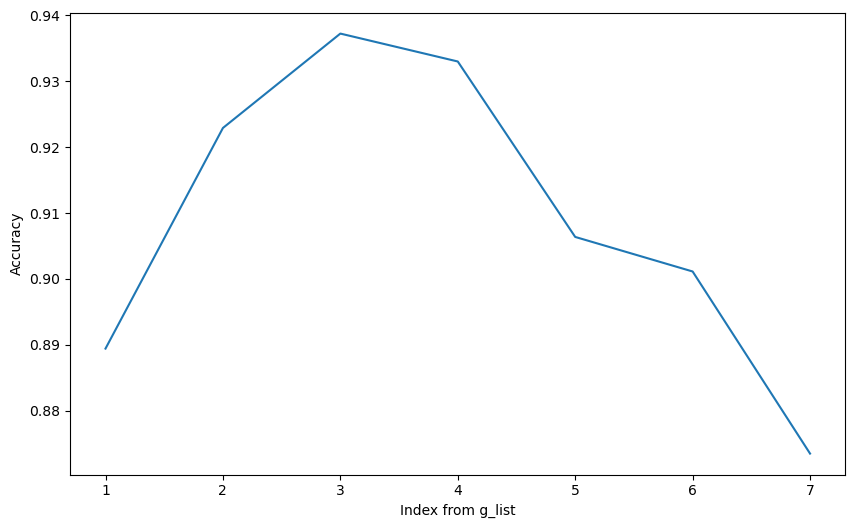

In [53]:
# Code adapted from: 
# [https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning].

# create list of accuracy scores for each value of g and print them
SVM_g_mean_acc = []
g_list = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
for i in g_list:
    SVM_clf_g_tune = SVC(gamma = i)
    SVM_g_score = cross_val_score(SVM_clf_g_tune, X_train_fs_std, y_train, 
                                  cv = kf, scoring = 'accuracy')
    SVM_g_score_mean = SVM_g_score.mean()
    SVM_g_mean_acc.append(SVM_g_score_mean)
    print(f"{i}: %.3f:" %(SVM_g_score_mean))

# plot accuracy scores against index of g_list
loc = np.arange(1, 8, step = 1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1, 8), SVM_g_mean_acc)
plt.xticks(loc)
plt.xlabel('Index from g_list')
plt.ylabel('Accuracy')
plt.savefig("g_tuning.png")
plt.show()

#### Multi-parameter Tuning

In [54]:
### This code chunk takes a long time to load ###

# Code adapted from: 
# [https://www.kaggle.com/code/arunimsamudra/k-nn-with-hyperparameter-tuning].

# define parameter range
SVM_param_grid = {'C': [1, 5, 10], 
                  'gamma': [0.1, 0.05],
                  'kernel': ['linear', 'rbf', 'poly'],
                  'degree': [2, 3, 4, 5]}

# fit models in parameter range
SVM_grid = GridSearchCV(SVC(), SVM_param_grid, refit = True, 
                        verbose = 1,  cv = kf)
SVM_grid.fit(X_train_fs_std, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [1, 5, 10], 'degree': [2, 3, 4, 5],
                         'gamma': [0.1, 0.05],
                         'kernel': ['linear', 'rbf', 'poly']},
             verbose=1)

In [55]:
# print best parameters
print(SVM_grid.best_params_)
print(SVM_grid.best_score_)

{'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
0.9402720755946563


# Evaluation

## Standardise and Apply Feature Selection to Test Data

In [56]:
# create new X test with selected features
X_test_fs = pd.DataFrame(X_test)
X_test_fs = X_test_fs[feature_df['index']]
X_test_fs = np.asarray(X_test_fs)
print(X_test_fs.shape)

# standardise X test data set
stand_scaler.fit(X_test_fs)
X_test_fs_std = stand_scaler.transform(X_test_fs)

(2125, 10)


## Best kNN Model Evaluation on Unseen Test Data

Tuned kNN

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      1791
         1.0       0.83      0.63      0.72       334

    accuracy                           0.92      2125
   macro avg       0.88      0.80      0.84      2125
weighted avg       0.92      0.92      0.92      2125



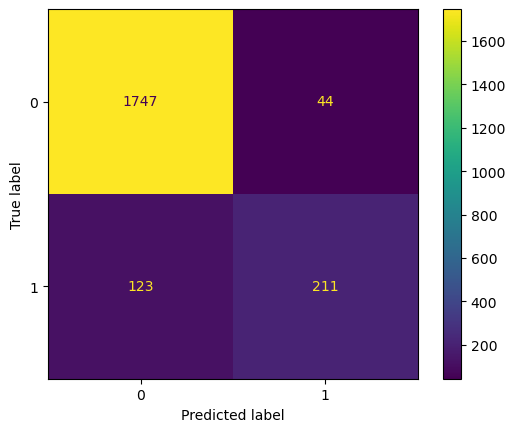

      0 = Existing Customer     1 = Attrited Customer



In [57]:
kNN_tuned_pred = kNN_grid.predict(X_test_fs_std)

# classification report
print('Tuned kNN\n')
print(classification_report(y_test, kNN_tuned_pred))

# confusion matrix
kNN_tuned_cm = confusion_matrix(y_test, kNN_tuned_pred, labels = [0, 1])
kNN_tuned_disp = ConfusionMatrixDisplay(confusion_matrix = kNN_best_cm,
                                        display_labels = [0, 1])
kNN_tuned_disp.plot()
plt.savefig("kNN_tuned.png")
plt.show()
print(class_key)

## Best SVM Model Evaluation on Unseen Test Data

Tuned SVM

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      1791
         1.0       0.85      0.78      0.81       334

    accuracy                           0.94      2125
   macro avg       0.91      0.88      0.89      2125
weighted avg       0.94      0.94      0.94      2125



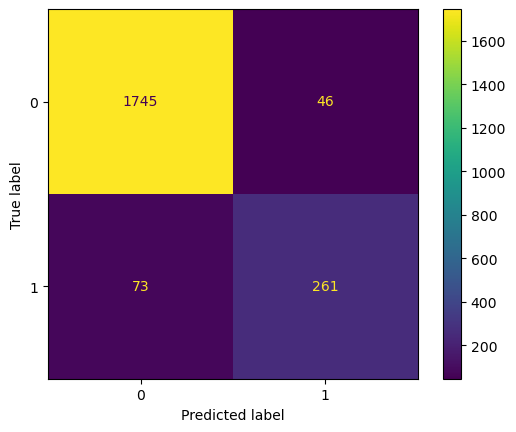

      0 = Existing Customer     1 = Attrited Customer



In [58]:
SVM_tuned_pred = SVM_grid.predict(X_test_fs_std)

# classification report
print('Tuned SVM\n')
print(classification_report(y_test, SVM_tuned_pred))

# confusion matrix
SVM_tuned_cm = confusion_matrix(y_test, SVM_tuned_pred, labels = [0, 1])
SVM_tuned_disp = ConfusionMatrixDisplay(confusion_matrix = SVM_best_cm,
                                        display_labels = [0, 1])
SVM_tuned_disp.plot()
plt.savefig("SVM_tuned.png")
plt.show()
print(class_key)